In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('/content/drive/MyDrive/28. 20220126_DAY27(1주차 모의경진대회)/data/train.csv')
df.head(20)

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.00,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.00,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.00,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.00,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.00,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1
5,0.1318,90000.00,3.48,7,0,0,2903,31,0,0,0,19548,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,7000,7000.0,0.0,1,7,236.47,0.854,0.0,0.0,1330.30,660,664,0
6,0.0791,60000.00,17.34,0,0,0,20399,35,0,0,0,117320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,20000,20000.0,0.0,1,18,625.90,0.369,0.0,0.0,2567.44,750,754,0
7,0.0975,79600.00,15.97,3,0,1,6481,17,0,0,0,18757,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,23800,23800.0,0.0,1,7,765.17,0.745,0.0,0.0,3006.76,680,684,0
8,0.0789,150000.00,7.36,1,0,0,15827,38,0,0,543,367504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,16000,16000.0,0.0,1,19,500.58,0.334,0.0,0.0,1286.38,665,669,0
9,0.0999,95000.00,25.78,0,1,0,17870,37,0,0,0,273776,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,24,258.10,0.764,0.0,0.0,796.59,665,669,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   int_rate                    100000 non-null  float64
 1   annual_inc                  100000 non-null  float64
 2   dti                         100000 non-null  float64
 3   delinq_2yrs                 100000 non-null  int64  
 4   inq_last_6mths              100000 non-null  int64  
 5   pub_rec                     100000 non-null  int64  
 6   revol_bal                   100000 non-null  int64  
 7   total_acc                   100000 non-null  int64  
 8   collections_12_mths_ex_med  100000 non-null  int64  
 9   acc_now_delinq              100000 non-null  int64  
 10  tot_coll_amt                100000 non-null  int64  
 11  tot_cur_bal                 100000 non-null  int64  
 12  chargeoff_within_12_mths    100000 non-null  int64  
 13  delinq_amnt    

In [3]:
X = df.drop('depvar', axis=1)
y = df['depvar']

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [72]:
# 하이퍼 파라미터 튜닝
xgb_clf = xgboost.XGBClassifier(tree_method='gpu_hist',
                                gpu_id=0,
                                seed=42)

param_grid = {'max_depth':[7],
              'n_estimators':[175],
              'lambda':[2],
              'scale_pos_weight':[2],
              'gamma' : [0],
              'eta' : [0.1],
              'alpha' : [1],
              'min_child_weight' : [3]
              }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='f1_macro', 
                           error_score=0) 

xgb_clf_results=grid_search.fit(X_train, y_train)

xgb_clf_results.best_params_

{'alpha': 1,
 'eta': 0.1,
 'gamma': 0,
 'lambda': 2,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 175,
 'scale_pos_weight': 2}

In [74]:
# best parameter를 사용하여 prediction 수행
xgb_clf = xgboost.XGBClassifier(max_depth = xgb_clf_results.best_params_['max_depth'],
                                n_estimators = xgb_clf_results.best_params_['n_estimators'],
                                eval_metric='mlogloss',
                                objective= 'binary:logistic' ,
                                alpha= xgb_clf_results.best_params_['alpha'],
                                eta=xgb_clf_results.best_params_['eta'],
                                gamma=xgb_clf_results.best_params_['gamma'],
                                
                                reg_lambda=xgb_clf_results.best_params_['lambda'],
                                scale_pos_weight=xgb_clf_results.best_params_['scale_pos_weight'],
                                min_child_weight=xgb_clf_results.best_params_['min_child_weight'],
                                )

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_valid)

In [76]:
# y_valid가 0 또는 1일 확률 출력
y_pred_prob = xgb_clf.predict_proba(X_valid)

print(len(y_pred_prob))
y_pred_prob

20000


array([[0.73020864, 0.26979136],
       [0.7055428 , 0.29445723],
       [0.7015111 , 0.29848891],
       ...,
       [0.7191428 , 0.2808572 ],
       [0.5459248 , 0.45407522],
       [0.303483  , 0.696517  ]], dtype=float32)

In [77]:
# y_valid가 1일 확률 출력
y_pred_prob[:,1]

array([0.26979136, 0.29445723, 0.29848891, ..., 0.2808572 , 0.45407522,
       0.696517  ], dtype=float32)

In [78]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred, average='macro')
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')


정확도: 0.7417
정밀도: 0.5878
재현율: 0.6945
AUC: 0.7295
F1: 0.7181


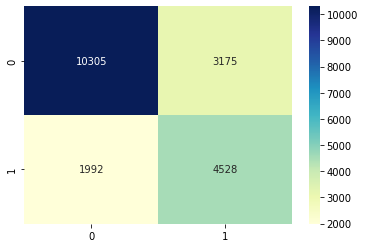

In [79]:
# xgboost 성능 확인
get_clf_eval(y_valid, y_pred_xgb)


정확도: 0.7387
정밀도: 0.5819
재현율: 0.7048
AUC: 0.7299
F1: 0.7166


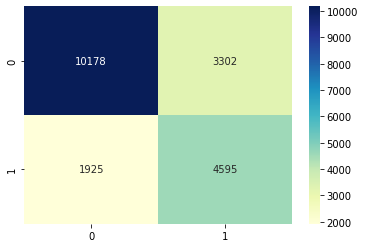

In [83]:
# threshold 변경 및 성능 확인
get_clf_eval(y_valid, y_pred_prob[:,1] > 0.49)

In [84]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/28. 20220126_DAY27(1주차 모의경진대회)/data/sample_submission.csv')
submit.head()

,ID,answer
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [86]:
# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/28. 20220126_DAY27(1주차 모의경진대회)/data/test.csv')
submit['answer'] = xgb_clf.predict(df_test.drop(columns=['ID']))#)[:,1] > 0.33) * 1

submit.head(20)

,ID,answer
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,0
6,6,1
7,7,1
8,8,0
9,9,1


In [87]:

# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/prediction6.csv', index=False)